In [59]:
import os

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random

import logging
import time
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

In [27]:
from google.colab import drive
drive.mount('/content/drive')
#file_path = '/content/drive/MyDrive/boilers_drive/normalized_df.csv'
train_csv_path = '/content/drive/MyDrive/boilers_drive/train_df.csv'
val_csv_path = '/content/drive/MyDrive/boilers_drive/val_df.csv'
test_csv_path = '/content/drive/MyDrive/boilers_drive/test_df.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Specify the file path of your CSV file

# Read the CSV file
train_data = pd.read_csv(train_csv_path)
val_data = pd.read_csv(val_csv_path)
test_data = pd.read_csv(test_csv_path)

In [86]:
#print(train_data)
#print(val_data)
#print(test_data)

In [30]:
# load pre-prepared random order of houses

random_order_houses = pd.read_csv('/content/drive/MyDrive/boilers_drive/random_order_houses.csv')

In [50]:
# Different houses in data
houses = random_order_houses['house_id'].unique().tolist()
print("Different houses in data:")
print(houses)
print("Number of different houses:")
print(len(houses))

Different houses in data:
['home9', 'home114', 'home5', 'home89', 'home17', 'home63', 'home2', 'home101', 'home14', 'home95', 'home111', 'home67', 'home77', 'home43', 'home86', 'home90', 'home47', 'home110', 'home93', 'home53', 'home34', 'home51', 'home106', 'home46', 'home79', 'home55', 'home65', 'home13']
Number of different houses:
28


In [32]:
#house_datasets = {}
#for house in houses:
#    house_datasets[house] = data[data['house_id'] == house]

#print(house_datasets)

**Preparing the data**

In [33]:
# the categories for prediction
final_category = 'blr_mod_lvl'
prediction_categories = ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out']
normalized_categories = ['normalized_blr_mod_lvl', 'normalized_absorption', 'normalized_insulation', 'normalized_t_r_set', 'normalized_t_out']

In [34]:
# creating sub-lists, each with the data of one day
# the function that gets category data of a house (ordered by date) and separates by day
def separate_into_days(data_list, minutes_per_day=1440):
    # number of days
    num_days = len(data_list) // minutes_per_day
    # the data into a list of sub-lists, each containing one day's data
    separated_data = [
        data_list[i * minutes_per_day:(i + 1) * minutes_per_day]
        for i in range(num_days)
    ]
    return separated_data


# function to "combine" values of categories and separate into sub-lists based on days
def combine_categories(dataset, categories_list):
    # Combine specified categories into lists
    combined_elements = dataset[categories_list].apply(lambda row: row.tolist(), axis=1)
    return combined_elements.tolist()

In [35]:
def prepare_data_2(house_data, input_categories, output_category, minutes_per_day=1440):
    combined_input_data = combine_categories(house_data, input_categories)
    separated_input_data = separate_into_days(combined_input_data, minutes_per_day)
    output = house_data[output_category].values
    separated_output = separate_into_days(output, minutes_per_day)
    # [:, :-1] and [:, 1:] for 2-d arrays
    # [:-1],  and [1:] for 1-d arrays (or lists)
    # all except last day are inputs (for prediction)
    input_data = separated_input_data[:-1]
    # all except first day are the corresponding outputs (from prediction)
    output_data = separated_output[1:]
    return input_data, output_data

In [53]:
# function for getting input and target data
def input_target_split (data, input_categories, num_of_houses):
    filtered_data = data[['house_id', 'time', 'normalized_blr_mod_lvl', 'normalized_absorption', 'normalized_insulation', 'normalized_t_r_set', 'normalized_t_out']].copy()
    input_chosen_categories = []
    for cat in input_categories:
        input_chosen_categories.append('normalized_'+cat)

    # We have 1440 minutes per day
    minutes_per_day = 1440

    # Initialize lists to store input and target pairs
    input_data_list, target_data_list = [], []

    for house_id in houses[:num_of_houses]:
        house_data = filtered_data[filtered_data['house_id'] == house_id]
        house_data = house_data.sort_values(by='time')
        input_data, target_data = prepare_data_2(house_data, input_chosen_categories, 'normalized_blr_mod_lvl')
        input_data_list.append(input_data)
        target_data_list.append(target_data)

    # Combine all houses' data
    input_data = np.concatenate(input_data_list, axis=0)
    target_data = np.concatenate(target_data_list, axis=0)

    return input_data, target_data


In [104]:
input_categories = ['blr_mod_lvl']

#num_of_houses = 1
num_of_houses = 3
#num_of_houses = len(houses)

In [105]:
input_train, target_train = input_target_split(train_data, input_categories, num_of_houses)
input_val, target_val = input_target_split(val_data, input_categories, num_of_houses)
input_test, target_test = input_target_split(test_data, input_categories, num_of_houses)

In [106]:
batch_size = 8 # Reduce the batch size, in case it helps !

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train))
train_dataset = train_dataset.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((input_val, target_val))
val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((input_test, target_test))
test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# The validation_split argument is designed to work with NumPy arrays or TensorFlow tensors,
# where it can easily split the data based on a fraction.
# It doesn't directly work with TensorFlow datasets because they handle data differently.

In [107]:
print(input_train.shape)
print(target_train.shape)
print(input_val.shape)
print(target_val.shape)
print(input_test.shape)
print(target_test.shape)
num_of_categories = input_train.shape[-1]
print("Number of categories for prediction: "+str(num_of_categories))

(285, 1440, 1)
(285, 1440)
(71, 1440, 1)
(71, 1440)
(89, 1440, 1)
(89, 1440)
Number of categories for prediction: 1


In [108]:
# Define the Transformer model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1440, num_of_categories)))
model.add(Dense(1))


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [109]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with the EarlyStopping callback
history = model.fit(
    train_dataset,       # Training dataset
    epochs=20,          # Number of epochs
    validation_data=val_dataset,  # Validation dataset
    callbacks=[early_stopping]  # List of callbacks to apply during training
)
# change epochs, patience , etc !!! (e.g. epochs=10, patience=3  or  epochs=20, patience=5)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0040 - mean_absolute_error: 0.0257 - val_loss: 0.0039 - val_mean_absolute_error: 0.0159
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0038 - mean_absolute_error: 0.0218 - val_loss: 0.0039 - val_mean_absolute_error: 0.0197
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0033 - mean_absolute_error: 0.0202 - val_loss: 0.0039 - val_mean_absolute_error: 0.0312
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0036 - mean_absolute_error: 0.0240 - val_loss: 0.0038 - val_mean_absolute_error: 0.0230
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0038 - mean_absolute_error: 0.0244 - val_loss: 0.0038 - val_mean_absolute_error: 0.0212
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0036 - mean_absolute_error: 0.0239 - val_loss: 0.0038 - val_mean_absolute_error: 0.0206
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0038 - mean_absolute_error: 0.0226 - val_loss

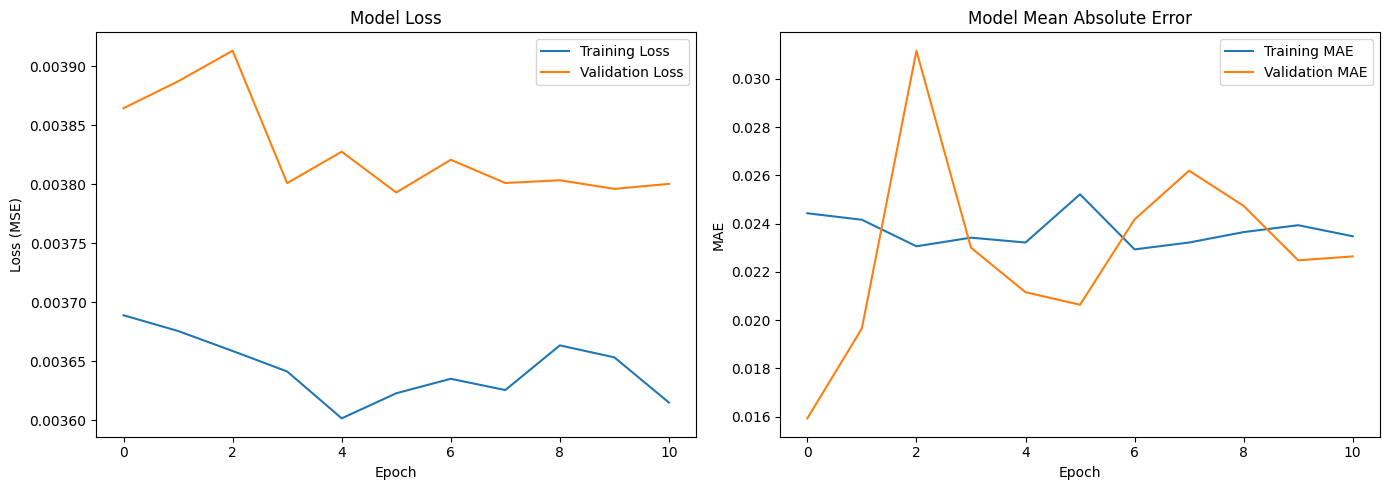

In [110]:
# Plotting the training and validation loss and MAE
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [111]:
# save the model
# !!! I need to save the scalers and the input_test, target_test, test_dataset as well !!!
# !!! Or I need to use the same for all models (save once and use for all) !!!
categories_used = '_'.join(input_categories)
houses_used = str(num_of_houses)

save_path='/content/drive/Othercomputers/My_Laptop/code/models/'
model_name = 'lstm_'+categories_used+"_houses_"+houses_used

# save trained model
model.save(save_path + model_name + '.keras')

# save history of training
with open(save_path + model_name + '_history.pkl', 'wb') as f:
  pickle.dump(history.history, f)

In [112]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_dataset, return_dict=True)
#print(f"Test Loss (MSE): {test_results['loss']}, Test MAE: {test_results['mean_absolute_error']}")

# model.predict() !!! (not model.evaluate)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - mean_absolute_error: 0.0140


In [113]:
test_predictions = model.predict(test_dataset)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [114]:
print(test_predictions.shape)

(89, 1440, 1)
